In [1]:
import torch
import torchvision
import torchvision.datasets as datasets
from torch.utils.data import Dataset, DataLoader,random_split # önemli kütüphanelerin import edilmesi
import torchvision.transforms as transforms
import torch.nn as nn
import numpy as np
from torchvision import models
import matplotlib.pyplot as plt 
%matplotlib inline

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') # GPU kontrolü

transform = transforms.Compose(
    [transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])]) # Resimin ImageNet Standartlarında normalize edilmesi

In [2]:
data = datasets.ImageFolder('./sar_data/', transform = transform) # dataset oluşturulması

np.random.seed(42)

train_size = int(0.70 * len(data)) # istenilen oranda datasetin train/test şeklinde bölünmesi
test_size = len(data) - train_size
train_dataset, test_dataset = random_split(data, [train_size, test_size])
print(f"Dataset has {len(data)} data points.")
print(f"Train Dataset has {len(train_dataset)} data points")
print(f"Test Dataset has {len(test_dataset)} data points.") 

Dataset has 1628 data points.
Train Dataset has 1139 data points
Test Dataset has 489 data points.


In [3]:
###HYPERPARAMETERS###
batch_size = 16
num_epochs = 30
learning_rate = 0.01
###HYPERPARAMETERS###

In [4]:
test_dataset[325]
alongside_cout = building_cout = road_cout = vegetation_cout = water_cout = 0
train_alongside_cout = train_building_cout = train_road_cout = train_vegetation_cout = train_water_cout = 0
for x in range(len(test_dataset)):
    a, b = test_dataset[x]
    if b == 0:
        alongside_cout +=1
    if b == 1:
        building_cout+=1
    if b == 2:
        road_cout+=1
    if b == 3:
        vegetation_cout+=1
    if b == 4:
        water_cout+=1

for x in range(len(train_dataset)):
    a, b = train_dataset[x]
    if b == 0:
        train_alongside_cout +=1
    if b == 1:
        train_building_cout+=1
    if b == 2:
        train_road_cout+=1
    if b == 3:
        train_vegetation_cout+=1
    if b == 4:
        train_water_cout+=1

print(f"Alongside number of samples in train set : {train_alongside_cout}") # hangi kategoride kaç veri var
print(f"Alongside number of samples in test set : {alongside_cout}")
print(f"Building number of samples in train set : {train_building_cout}")
print(f"Building number of samples in test set : {building_cout}")
print(f"Road number of samples in train set : {train_road_cout}")
print(f"Road number of samples in test set : {road_cout}")
print(f"Vegetation number of samples in train set : {train_vegetation_cout}")
print(f"Vegetation number of samples in test set : {vegetation_cout}")
print(f"Water number of samples in train set : {train_water_cout}")
print(f"Water number of samples in test set : {water_cout}")

train_loader = DataLoader(train_dataset, batch_size= batch_size, shuffle= True)

test_loader = DataLoader(test_dataset, batch_size= batch_size, shuffle= False)

Alongside number of samples in train set : 150
Alongside number of samples in test set : 66
Building number of samples in train set : 270
Building number of samples in test set : 122
Road number of samples in train set : 292
Road number of samples in test set : 100
Vegetation number of samples in train set : 217
Vegetation number of samples in test set : 95
Water number of samples in train set : 210
Water number of samples in test set : 106


In [5]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(7744, 2560)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(2560, 100)
        self.relu4 = nn.ReLU()
        self.fc3 = nn.Linear(100, 5)
        self.relu5 = nn.ReLU()

    def forward(self, x):
        y = self.conv1(x)
        y = self.relu1(y)
        y = self.pool1(y)
        y = self.conv2(y)
        y = self.relu2(y)
        y = self.pool2(y)
        y = y.view(y.shape[0], -1)
        y = self.fc1(y)
        y = self.relu3(y)
        y = self.fc2(y)
        y = self.relu4(y)
        y = self.fc3(y)
        y = self.relu5(y)
        return y

model = Model()
model.to(device)

#Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [6]:
import time
print_every = len(train_loader) - 1
loss_values = []
start_time = time.time()
total_step = len(train_loader)
epoch_times = []

for epoch in range(num_epochs):
    running_loss = 0.0
    for i, (images, labels) in enumerate(train_loader): ###TRAİNİNG_LOOP
        epoch_start_time = time.time()
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item() 
        if (i+1) % print_every == 0:
            epoch_times.append(time.time() - epoch_start_time)
            loss_values.append(running_loss / print_every)
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}: Batch Loss : {}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item(), running_loss / print_every))
            running_loss = 0
end_of_training = time.time() - start_time

Epoch [1/30], Step [71/72], Loss: 1.2590: Batch Loss : 1.535857163684469
Epoch [2/30], Step [71/72], Loss: 0.8819: Batch Loss : 1.1635262109863926
Epoch [3/30], Step [71/72], Loss: 1.2344: Batch Loss : 0.9250344617266051
Epoch [4/30], Step [71/72], Loss: 0.6193: Batch Loss : 0.771934300241336
Epoch [5/30], Step [71/72], Loss: 1.0025: Batch Loss : 0.6961542489662976
Epoch [6/30], Step [71/72], Loss: 0.7077: Batch Loss : 0.6816861119488595
Epoch [7/30], Step [71/72], Loss: 0.3781: Batch Loss : 0.5970299430716206
Epoch [8/30], Step [71/72], Loss: 0.8030: Batch Loss : 0.5636829687675959
Epoch [9/30], Step [71/72], Loss: 0.5034: Batch Loss : 0.5117731023002678
Epoch [10/30], Step [71/72], Loss: 1.5539: Batch Loss : 0.5042620454455765
Epoch [11/30], Step [71/72], Loss: 0.6354: Batch Loss : 0.9185955054323438
Epoch [12/30], Step [71/72], Loss: 0.7231: Batch Loss : 0.8562547933887428
Epoch [13/30], Step [71/72], Loss: 0.1674: Batch Loss : 0.4882848783278129
Epoch [14/30], Step [71/72], Loss: 0

In [7]:
x_axis = np.arange(1,num_epochs + 1)

def find_interval_for_graph(end_of_training, num_epochs):
    interval = end_of_training / num_epochs
    return interval
interval = find_interval_for_graph(end_of_training, num_epochs)
x_interval_axis = np.arange(0, end_of_training, interval)

print(f"Total Training Time : {end_of_training} sn")

Total Training Time : 47.63495993614197 sn


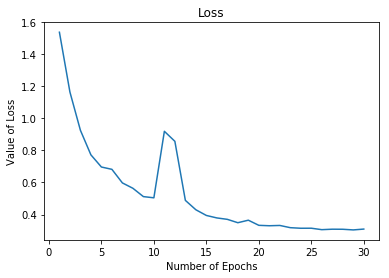

In [8]:
import matplotlib.pyplot as plt 

plt.title("Loss")
plt.ylabel("Value of Loss")
plt.xlabel("Number of Epochs")
plt.plot(x_axis, loss_values)

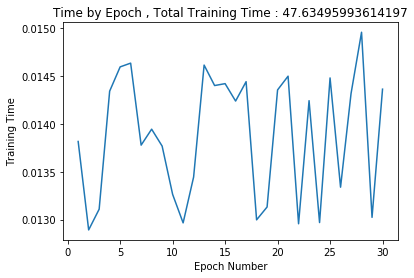

In [9]:
plt.title("Time by Epoch , Total Training Time : {}".format(end_of_training))
plt.ylabel("Training Time")
plt.xlabel("Epoch Number")
print(plt.plot(x_axis,epoch_times))

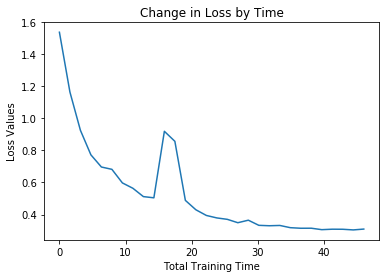

In [10]:
plt.title("Change in Loss by Time")
plt.ylabel("Loss Values")
plt.xlabel("Total Training Time")
plt.plot(x_interval_axis, loss_values)

In [11]:
arr_pred = np.empty((0,len(test_dataset)), int)

arr_label = np.empty((0,len(test_dataset)), int)

with torch.no_grad(): 
    correct = 0
    total = 0
    for images, labels in test_loader:  #PREDİCTİON LOOP
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        pred = predicted.cpu().numpy()
        lb = labels.cpu().numpy()
        arr_pred = np.append(arr_pred, pred)
        arr_label = np.append(arr_label, lb)
        
    print('Test Accuracy of the model on the 10000 test images: {} %'.format(100 * correct / total))

Test Accuracy of the model on the 10000 test images: 69.52965235173824 %


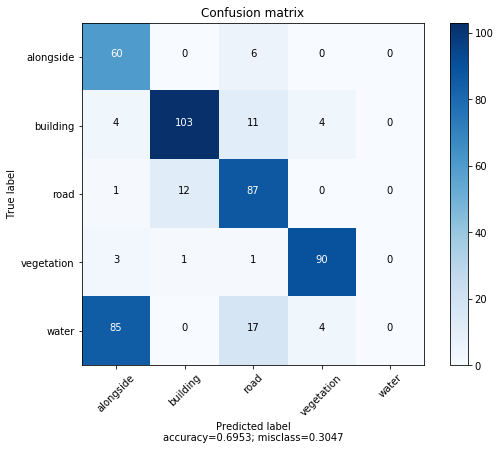

The Accuracy : 69.52965235173824
The Precision : 58.23139996529986
The Recall : 71.41443250451015
The F1 Score : 62.59835389594526


/home/merto/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/merto/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [12]:
from sklearn import metrics
from cm_helper import plot_confusion_matrix
cm = metrics.confusion_matrix(arr_label, arr_pred)
plot_confusion_matrix(cm, target_names= ["alongside", "building", "road" ,"vegetation", "water"], title='Confusion matrix' , normalize= False)


print(f"The Accuracy : { 100 * metrics.accuracy_score(arr_label, arr_pred)}")
print(f"The Precision : {100 * metrics.precision_score(arr_label, arr_pred, average= 'macro')}")
print(f"The Recall : {100 * metrics.recall_score(arr_label, arr_pred, average= 'macro')}")
print(f"The F1 Score : {100 *metrics.f1_score(arr_label, arr_pred, average = 'macro')}")